## 기본적인 SIR 모델을 PINN을 활용해서 풀어보자


In [2]:
# pytorch를 이용

import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import grad

# cpu사용할지 gpu사용할지
device = torch.device("cuda")

# Random seed
torch.manual_seed(2021)
np.random.seed(2021)

from scipy.integrate import odeint # SIR 모델을 위한 패키지

# SIR problem

Consider the following SIR problem:

$$\frac{dS}{dt}=-\beta \frac{SI}{N}, \quad t \in [0,20] $$
$$\frac{dI}{dt}=\beta \frac{SI}{N}-\gamma I $$
$$\frac{dR}{dt}=\gamma I $$
with $S(0)=99,I(0)=1,R(0)=0$ and 
where $S(t)$, $I(t)$ and $R(t)$ denote the population of the Suspective, Infected, and Recovered, respectively.

In [3]:
# SIR 모델 구현하기
def SIR(net, t, params):
    N, beta, gamma = params
    u = net.forward(t)
    S = u[:, 0:1]
    I = u[:, 1:2]
    R = u[:, 2:3]
    S_t = grad(S.sum(), t, create_graph=True)[0] # torch.grad(outputs, inputs, )
    I_t = grad(I.sum(), t, create_graph=True)[0]
    R_t = grad(R.sum(), t, create_graph=True)[0]
    u_t = torch.cat([S_t, I_t, R_t], dim = 1)
    loss_f = u_t + torch.cat([beta*S*I/N, -beta*S*I/N + gamma*I, -gamma*I], dim = 1) # 변화율 : 손실함수 정의
    loss_f = torch.mean(torch.square(loss_f)) # torch.square : 제곱
    return loss_f


# ODE initial parameter
N = 100
beta = 1.0
D = 4.0
gamma = 1.0/D
SIR.params = [N, beta, gamma]

# Initial condition
S0 = 99
I0 = 1
R0 = 0

# Time
t1 = 0
tr = 20


In [5]:
# 테스트 데이터 생성
def deriv(u, t, N, beta, gamma):
    S, I, R = u
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# 기간 설정
t = np.linspace(t1, tr, 501)

# 초기 조건 벡터
u0 = S0, I0, R0

# ode 시행
u = odeint(deriv, u0, t, args = (N, beta, gamma))

# 테스트 텐서 생성
X_test = torch.tensor(t, dtype = torch.float64, device = device).view(-1, 1)
U_test = torch.tensor(u, dtype = torch.float64, device = device).view(-1, 3)

# pde 풀기 위한 초기 조건
N_colloc = 2000

# Collocation points
X_colloc = torch.rand(N_colloc, dtype = torch.float64, device = device).view(-1, 1) * (tr - t1) + t1
X_colloc.requires_grad_() # requires_grad : 역전파를 위한 변수(변화할 것)이라는 것을 알려줌)

# Input 데이터를 정규화
X_mean = torch.mean(X_colloc, 0).detach()
X_std = torch.std(X_colloc, 0).detach()

# 초기 training 포인트
X_ic = torch.tensor([0], dtype = torch.float64, device = device).view(-1, 1)
U_ic = torch.tensor([S0, I0, R0], dtype = torch.float64, device = device).view(-1, 3)

# Output 정규화
U_mean = torch.mean(U_ic)
U_std = torch.std(U_ic)

# L2 error 계산
def calculate_relative_err(net):
    U_pred = net.predict(X_test)
    err = torch.abs(U_pred - U_test)
    err = torch.linalg.norm(err)/torch.linalg.norm(U_test)
    return err.item()

In [6]:
# PINN class for BVP and LotkaVolterra
class PINN(nn.Module):   
    def __init__(self,
                governing_eqn = None,
                Fourier_embedding = True,
                layers = [50,50,50,50],
                X_colloc=X_colloc):
        
        super(PINN, self).__init__()
        
        # Basic settings
        self.Fourier_embedding = Fourier_embedding
        self.governing_eqn = governing_eqn
        self.params = governing_eqn.params
        self.device = device
        self.X_colloc=X_colloc

        # Input and output dimension
        input_dim = 1
        output_dim = 3

        # For Fourier embedding
        if self.Fourier_embedding == True:
            sigma = 2
            input_dim = 20
            self.B = nn.Parameter(sigma*torch.randn(1,int(0.5*input_dim),dtype=torch.float64),requires_grad=False)

        # Set neural network structure
        hidden = [50,50,50,50]
        self.n_hidden = len(hidden)
        self.fcs = nn.ModuleList()
        for layer in range(self.n_hidden+1):
            self.fcs.append(nn.Sequential(*[nn.Linear(in_features = input_dim if layer == 0 else hidden[layer -1],
                                                  out_features = output_dim if layer == self.n_hidden else hidden[layer],
                                                  bias = True)]))
        
            # Initialization of weights and biases for each layer
            nn.init.xavier_normal_(self.fcs[layer][0].weight)
            nn.init.zeros_(self.fcs[layer][0].bias)
        
    # Fourier Embedding layer funtion
    def Fourier(self,X):
        X = X@self.B
        X = torch.cat((torch.sin(X),torch.cos(X)),-1)
        return X

    # Forward pass function 
    def forward(self, x):
        # Normalization for input
        x = (x-X_mean)/X_std

        # If Fourier embedding is used, apply the Fourier embedding layer
        if self.Fourier_embedding ==True:
            x = self.Fourier(x)

        # Pass each layer and apply activation function
        for i in range(self.n_hidden):    
            x = self.fcs[i](x)
            x = torch.sin(x)
        # Final layer does not have activation function
        x = self.fcs[self.n_hidden](x)

        # Denormalize for output
        x = U_std*x+U_mean
        return x

    def loss_func(self):
        # Residual Loss
        loss_colloc = self.governing_eqn(self,self.X_colloc,self.params)
        
        # Initial Loss
        U_ic_pred = self.forward(X_ic)
        loss_ic = torch.mean(torch.square(U_ic_pred-U_ic))

        return loss_colloc + 100*loss_ic

    def train(self,num_iter=10000):
        # Initialize history lists
        self.loss_history = []
        self.l2error_history = []

        # Save history for every 50 iteration
        self.history_interval = 100

        # Set optimizer
        optimizer = torch.optim.Adam(self.parameters(),lr = 0.001,betas=(0.999,0.999))
        
        # Trining time check
        start = time.time()
        
        for count in range(num_iter):
            # Zero gradients
            optimizer.zero_grad()
            
            # compute loss
            loss = self.loss_func()
            
            # compute gradients (backward pass)
            loss.backward()
            
            # update parameters using gradients
            optimizer.step()

            # For loss and l2error history
            if count % self.history_interval == 0:
                err = calculate_relative_err(net)
                self.loss_history.append(loss.detach().item())
                self.l2error_history.append(err)

            # For loss print
            if count % 5000 == 0:
                print(f"Iter: {count}, Loss: {self.loss_history[int(count/self.history_interval)]}")

        end = time.time()
        print(f"Training time: {end-start} seconds")
        
    # Predict for a new input
    def predict(self,X_new):
        pred_outs = self.forward(X_new)
        return pred_outs

In [7]:
# Set number of training points
# N_colloc = 2000

# Make a PINN network
net = PINN(governing_eqn=SIR,
            Fourier_embedding=True,
            layers = [50,50,50,50],X_colloc=X_colloc).to(device).double()
# Train PINN
net.train(num_iter=20000)


Iter: 0, Loss: 192397.66567893402
Iter: 5000, Loss: 13.858629374887734
Iter: 10000, Loss: 0.35009859679840805
Iter: 15000, Loss: 0.022877889698092617
Training time: 233.38509130477905 seconds


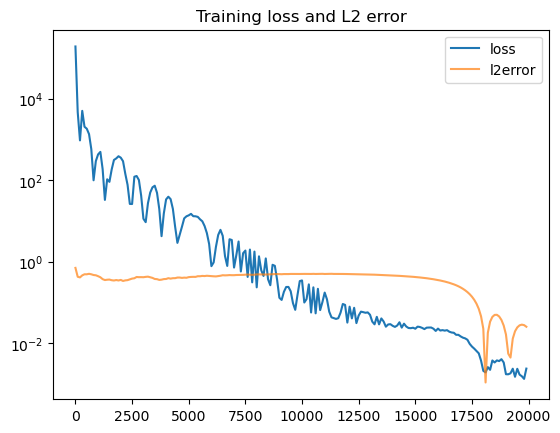

In [8]:
plt.figure()
plt.title("Training loss and L2 error")
plt.semilogy(net.history_interval*np.arange(0,int(len(net.loss_history))).reshape(-1,1),net.loss_history,label = "loss")
plt.semilogy(net.history_interval*np.arange(0,int(len(net.l2error_history))).reshape(-1,1),net.l2error_history,label = 'l2error',alpha=0.7)
plt.legend()
plt.show()

Relative L2-error norm: 0.021793951710986484


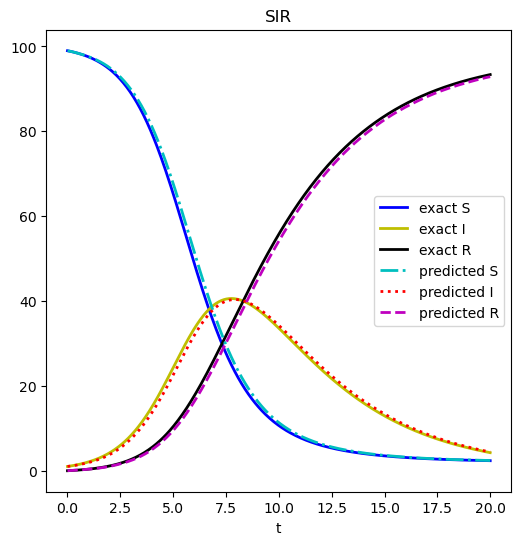

In [9]:
# Make prediction using learned network
U_pred = net.predict(X_test)
err = torch.abs(U_pred-U_test)
err = torch.linalg.norm(err)/torch.linalg.norm(U_test)
print("Relative L2-error norm: {}".format(err))

with torch.no_grad():
    plt.figure(figsize=(6,6))
    plt.title("SIR")
    plt.plot(X_test.cpu(),U_test.cpu()[:,0:1],'b', lw=2, label='exact S')
    plt.plot(X_test.cpu(),U_test.cpu()[:,1:2],'y', lw=2, label='exact I')
    plt.plot(X_test.cpu(),U_test.cpu()[:,2:3],'k', lw=2, label='exact R')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,0:1],'c-.', lw=2, label='predicted S')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,1:2],'r:', lw=2, label='predicted I')
    plt.plot(X_test.cpu(),U_pred.cpu()[:,2:3],'m--', lw=2, label='predicted R')
    plt.legend()
    plt.xlabel('t')
    plt.show()